In [29]:
%matplotlib inline

import datacube
from datacube.testutils import io


In [3]:
dc = datacube.Datacube(app='s2')
dc.list_products()

,name,description,gqa_mean_y,dataset_maturity,instrument,lat,creation_time,gqa_abs_iterative_mean_xy,platform,gqa_abs_xy,...,fmask_snow,eo_gsd,gqa_mean_x,gqa_iterative_mean_x,gqa_stddev_y,gqa_mean_xy,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,,,,,,,
14,alos_palsar_mosaic,ALOS/PALSAR and ALOS-2/PALSAR-2 annual mosaic ...,NaN,NaN,PALSAR/PALSAR-2,None,None,NaN,ALOS/ALOS-2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:4326,"(-0.000222222222222, 0.000222222222222)","(5, 5)","(latitude, longitude)"
17,ga_ls8c_gm_2_annual,"Annual Geometric Median, Landsat 8",NaN,NaN,None,None,None,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:6933,"(-30, 30)","(150000.0, 150000.0)","(y, x)"
15,ga_ls8c_wofs_2,Historic Flood Mapping Water Observations from...,NaN,NaN,None,None,None,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,ga_ls8c_wofs_2_annual_summary,Water Observations from Space Annual Statistics,NaN,NaN,None,None,None,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:6933,"(-30, 30)","(150000.0, 150000.0)","(y, x)"
16,ga_ls8c_wofs_2_summary,Water Observations from Space Full History Sta...,NaN,NaN,None,None,None,NaN,None,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:6933,"(-30, 30)","(150000.0, 150000.0)","(y, x)"
21,jers_sar_tile,JERS-1 SAR annual mosaic tiles generated for u...,NaN,NaN,SAR,None,None,NaN,JERS-1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,EPSG:4326,"(-0.000222222222222, 0.000222222222222)","(5, 5)","(latitude, longitude)"
3,ls5_usgs_sr_scene,Landsat 5 USGS Collection 1 Level2 Surface Ref...,NaN,NaN,TM,None,None,NaN,LANDSAT_5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ls7_usgs_sr_scene,Landsat 7 USGS Collection 1 Level2 Surface Ref...,NaN,NaN,ETM,None,None,NaN,LANDSAT_7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ls8_usgs_sr_scene,Landsat 8 USGS Collection 1 Higher Level SR sc...,NaN,NaN,OLI_TIRS,None,None,NaN,LANDSAT_8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
query = {}
query['product'] = 'ls8_usgs_sr_scene'
query['id'] = '13b9c5f0-65f0-5d2e-8473-5bbfc92a9673'
query['measurements'] = ['green','swir1']

In [20]:
ds = dc.find_datasets(**query)

In [21]:
query['output_crs'] = ds[0].metadata_doc['grid_spatial']['projection']['spatial_reference']
query['resolution'] = (-30,30)

In [39]:
l2_data = dc.load(**query)

In [40]:
l2_data

<xarray.Dataset>
Dimensions:      (time: 1, x: 7600, y: 7760)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-09T11:22:11.054208
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Data variables:
    green        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    swir1        (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
Attributes:
    crs:           epsg:32628
    grid_mapping:  spatial_ref

In [37]:
l1_green = io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B3.tiff')

In [36]:
l1_swir1 =  io.rio_slurp_xarray('LC08_L1TP_204052_20180109_20180119_01_T1_B6.tiff')

In [38]:
l1_green

<xarray.DataArray (y: 7761, x: 7601)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Attributes:
    nodata:   None

## From here it's Ee Faye

### Calculating MNDWI for Level 2 data

In [43]:
# This def is from Caitlin's notebook, note NVDI and NDWI have been removed here
# Note typo in original def - MNDWI incorrectly uses NIR in the denominator

def calculate_band_indices(dc):
    dc['mndwi'] = (dc.green - dc.swir1)/(dc.green + dc.swir1)
    return(dc)

dc_level2 = calculate_band_indices(l2_data)

In [53]:
print(dc_level2.time)

# There is only one timestep here. I'm not sure why. It does not correspond to Caitlin's timesteps

<xarray.DataArray 'time' (time: 1)>
array(['2018-01-09T11:22:11.054208000'], dtype='datetime64[ns]')
Coordinates:
  * time         (time) datetime64[ns] 2018-01-09T11:22:11.054208
    spatial_ref  int32 32628
Attributes:
    units:    seconds since 1970-01-01 00:00:00


### Calculating MNDWI for Level 1 data

In [75]:
dc_level1 = np.nan_to_num((l1_green - l1_swir1)/(l1_green + l1_swir1))
print(dc_level1)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [51]:
print(l1_green)

<xarray.DataArray (y: 7761, x: 7601)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)
Coordinates:
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628
Attributes:
    nodata:   None


In [62]:
print(l1_swir1 / l1_green)

<xarray.DataArray (y: 7761, x: 7601)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 1.395e+06 1.395e+06 ... 1.162e+06 1.162e+06
  * x            (x) float64 3.039e+05 3.039e+05 ... 5.319e+05 5.319e+05
    spatial_ref  int32 32628


In [57]:
import numpy as np

In [73]:
#divtest = np.divide(l1_swir1, l1_green, out=np.zeros_like(l1_swir1), where=l1_green!=0)
divtest2 = np.nan_to_num(l1_swir1/l1_green)
print(divtest2)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


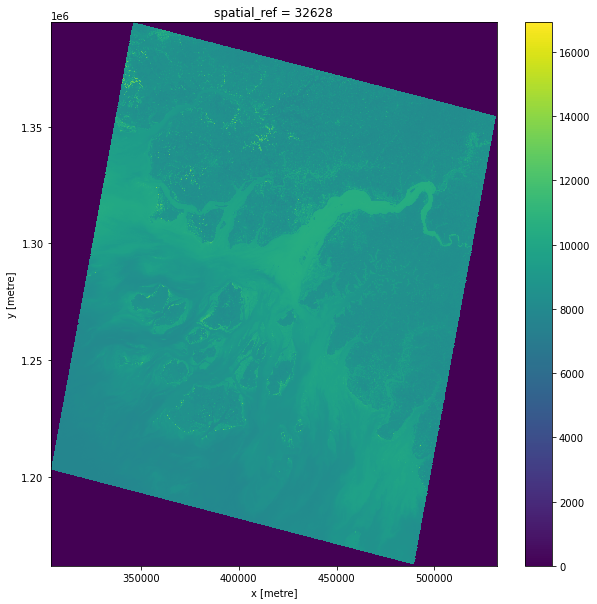

In [65]:
l1_green.plot(figsize = (10,10))